# Download data from Kaggle

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle # /root/.kaggle/kaggle.json
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 96% 209M/218M [00:01<00:00, 143MB/s]
100% 218M/218M [00:01<00:00, 131MB/s]


In [5]:
import os
os.makedirs('./dataset', exist_ok=True)

!unzip ./cat-and-dog.zip -d ./dataset/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.371.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3715.jpg  
  inflating: ./dataset/training_set/training_set/cats/cat.3716.jpg  

In [6]:
import numpy as np
import random
import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility

In [7]:
# For code reproducibility

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Create custom datasets & dataloaders

In [8]:
class MyData(Dataset):
    def __init__(self, type=0): # type0:train / type1:valid / type2: test
      self.img_list = []
      self.label_list = []
      typelist = ['training_set', 'training_set', 'test_set']

      cat_img_list = glob.glob(f'./dataset/{typelist[type]}/{typelist[type]}/cats/*.jpg')
      cat_label_list = [0 for i in range(len(cat_img_list))] # 0: cat / 1: dog
      self.img_list += cat_img_list
      self.label_list += cat_label_list

      dog_img_list = glob.glob(f'./dataset/{typelist[type]}/{typelist[type]}/dogs/*.jpg')
      dog_label_list = [1 for i in range(len(dog_img_list))] # 0: cat / 1: dog
      self.img_list += dog_img_list
      self.label_list += dog_label_list

      self.train_transform =  transforms.Compose([
                                            transforms.Resize((224,224)),
                                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
      self.val_transform = transforms.Compose([
                                            transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
      self.test_transform = transforms.Compose([
                                            transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

      self.type = type

    def __len__(self):
      return len(self.img_list)

    def __getitem__(self, index):
      img_path = self.img_list[index]
      label = self.label_list[index]
      img = Image.open(img_path).convert('RGB')

      if self.type == 0: # train
        img = self.train_transform(img)
      elif self.type == 1: # val
        img = self.val_transform(img)
      else: # test
        img = self.test_transform(img)

      return img, label

In [9]:
# Generating custom dataset

trainset = MyData(type=0)
valset = MyData(type=1)
testset = MyData(type=2)

print(f"# of train data: {len(trainset)}, # of test data: {len(testset)}")

# of train data: 8005, # of test data: 2023


In [10]:
# Splitting train/validation set

index = list(range(len(trainset)))
np.random.shuffle(index)
cutoff = int(len(index)*0.9)

train_idx = index[:cutoff] # 90%
val_idx = index[cutoff:] # 10%

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [11]:
# Generating train/val/test dataloader

train_loader = DataLoader(trainset, batch_size=128, sampler=train_sampler,
                            num_workers=2, shuffle=False, pin_memory=True)

val_loader = DataLoader(valset, batch_size=128, sampler=val_sampler,
                            num_workers=2, shuffle=False, pin_memory=True)

test_loader = DataLoader(testset, batch_size=1,
                            num_workers=2, shuffle=True, pin_memory=True)

# Define custom CNN model

In [12]:
# Defining a simple CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # 처음 input shape: [b, 3, 224, 224]

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1), # (in_channels, out_channels, kernel_size, stride, padding)
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU()
        ) # [b, 3, 112, 112]

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU()
        )  # [b, 32, 56, 56]

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 2, 1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU()
        )  # [b, 16, 14, 14]

        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )  # [b, 8, 7, 7]

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # [b, 8, 1, 1]
        self.linear = nn.Linear(8, 2) # [b, 2]

    def forward(self, input):
        ret = self.conv1(input)
        ret = self.conv2(ret)
        ret = self.conv3(ret)
        ret = self.conv4(ret)
        ret = self.gap(ret).squeeze()
        ret = self.linear(ret)

        return ret

In [13]:
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train & Validation with the custom CNN model

In [14]:
# hyperparameter setting

epochs = 32

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
best_acc = 0
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
os.makedirs('./weights', exist_ok=True)
dormant = 0

for epoch in range(epochs):
    avg_train_loss = AverageMeter()
    train_correct = 0
    train_total = 0

    # train
    model.train()
    for idx, i in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}"):
        data_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
        data_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

        out = model(data_x) # torch.tensor, [b, 2]
        pred_y = torch.argmax(out, dim=1) # [b]

        train_total += data_y.shape[0]
        for i in range(data_y.shape[0]):
            if torch.equal(pred_y[i], data_y[i]):
                train_correct += 1

        loss = torch.FloatTensor([0.]).to(device)
        loss += criterion(out, data_y)
        avg_train_loss.update(loss.item(), data_x.shape[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = avg_train_loss.avg
    train_acc = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ----------------------------------------------------------------------------------------
    # Evaluation(Validation set)
    avg_val_loss = AverageMeter()
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for idx, i in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation"):
            val_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
            val_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

            val_out = model(val_x) # torch.tensor, [b, 2]
            val_pred_y = torch.argmax(val_out, dim=1) # [b]

            val_total += val_y.shape[0]
            for j in range(val_y.shape[0]):
                if torch.equal(val_pred_y[j], val_y[j]):
                    val_correct += 1

            val_loss = torch.FloatTensor([0.]).to(device)
            val_loss += criterion(val_out, val_y)
            avg_val_loss.update(val_loss.item(), val_x.shape[0])

    val_loss = avg_val_loss.avg
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if best_acc < val_acc:
        print('\nHigher validation accuracy, saving model weights...')
        print('best acc: {:4f}'.format(best_acc), 'current acc: {:.4f}'.format(val_acc))
        best_acc = val_acc
        torch.save(model,'./weights/best.pt')
        dormant = 0

    if epoch % 1 == 0:
        print("\n[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f" %(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))
    print("★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★")

    dormant += 1
    if dormant == 10:
      print("\nEarly exiting...")
      break

print('Best validation accuracy: {:4f}'.format(best_acc))
print('Training Finished!')

Validation: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Higher validation accuracy, saving model weights...
best acc: 0.000000 current acc: 0.5830

[1/32] TrainLoss: 0.661, ValLoss: 0.675 | TrainAcc: 0.58, ValAcc: 0.58
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Higher validation accuracy, saving model weights...
best acc: 0.583021 current acc: 0.5918

[2/32] TrainLoss: 0.642, ValLoss: 0.647 | TrainAcc: 0.62, ValAcc: 0.59
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Higher validation accuracy, saving model weights...
best acc: 0.591760 current acc: 0.5980

[3/32] TrainLoss: 0.631, ValLoss: 0.642 | TrainAcc: 0.64, ValAcc: 0.60
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


[4/32] TrainLoss: 0.621, ValLoss: 0.771 | TrainAcc: 0.65, ValAcc: 0.58
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Higher validation accuracy, saving model weights...
best acc: 0.598002 current acc: 0.6305

[5/32] TrainLoss: 0.606, ValLoss: 0.644 | TrainAcc: 0.66, ValAcc: 0.63
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Higher validation accuracy, saving model weights...
best acc: 0.630462 current acc: 0.6529

[6/32] TrainLoss: 0.599, ValLoss: 0.609 | TrainAcc: 0.67, ValAcc: 0.65
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


[7/32] TrainLoss: 0.582, ValLoss: 0.628 | TrainAcc: 0.69, ValAcc: 0.65
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


[8/32] TrainLoss: 0.573, ValLoss: 0.831 | TrainAcc: 0.69, ValAcc: 0.60
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Higher validation accuracy, saving model weights...
best acc: 0.652934 current acc: 0.7054

[9/32] TrainLoss: 0.557, ValLoss: 0.558 | TrainAcc: 0.72, ValAcc: 0.71
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


[10/32] TrainLoss: 0.548, ValLoss: 0.728 | TrainAcc: 0.72, ValAcc: 0.63
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


[11/32] TrainLoss: 0.538, ValLoss: 0.557 | TrainAcc: 0.73, ValAcc: 0.69
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Higher validation accuracy, saving model weights...
best acc: 0.705368 current acc: 0.7316

[12/32] TrainLoss: 0.525, ValLoss: 0.542 | TrainAcc: 0.74, ValAcc: 0.73
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Higher validation accuracy, saving model weights...
best acc: 0.731586 current acc: 0.7403

[13/32] TrainLoss: 0.517, ValLoss: 0.528 | TrainAcc: 0.75, ValAcc: 0.74
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


[14/32] TrainLoss: 0.509, ValLoss: 0.604 | TrainAcc: 0.76, ValAcc: 0.70
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Higher validation accuracy, saving model weights...
best acc: 0.740325 current acc: 0.7441

[15/32] TrainLoss: 0.496, ValLoss: 0.508 | TrainAcc: 0.77, ValAcc: 0.74
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


[16/32] TrainLoss: 0.493, ValLoss: 0.509 | TrainAcc: 0.77, ValAcc: 0.74
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Higher validation accuracy, saving model weights...
best acc: 0.744070 current acc: 0.7615

[17/32] TrainLoss: 0.475, ValLoss: 0.481 | TrainAcc: 0.77, ValAcc: 0.76
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Higher validation accuracy, saving model weights...
best acc: 0.761548 current acc: 0.7753

[18/32] TrainLoss: 0.466, ValLoss: 0.485 | TrainAcc: 0.78, ValAcc: 0.78
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


[19/32] TrainLoss: 0.464, ValLoss: 0.559 | TrainAcc: 0.78, ValAcc: 0.73
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[20/32] TrainLoss: 0.452, ValLoss: 0.480 | TrainAcc: 0.79, ValAcc: 0.77
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


[21/32] TrainLoss: 0.455, ValLoss: 0.637 | TrainAcc: 0.79, ValAcc: 0.70
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Higher validation accuracy, saving model weights...
best acc: 0.775281 current acc: 0.8015

[22/32] TrainLoss: 0.440, ValLoss: 0.451 | TrainAcc: 0.80, ValAcc: 0.80
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


[23/32] TrainLoss: 0.443, ValLoss: 0.443 | TrainAcc: 0.80, ValAcc: 0.79
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


[24/32] TrainLoss: 0.436, ValLoss: 0.611 | TrainAcc: 0.80, ValAcc: 0.70
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


[25/32] TrainLoss: 0.425, ValLoss: 0.445 | TrainAcc: 0.80, ValAcc: 0.80
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


[26/32] TrainLoss: 0.424, ValLoss: 0.444 | TrainAcc: 0.81, ValAcc: 0.79
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


[27/32] TrainLoss: 0.427, ValLoss: 0.452 | TrainAcc: 0.81, ValAcc: 0.79
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


[28/32] TrainLoss: 0.415, ValLoss: 0.780 | TrainAcc: 0.81, ValAcc: 0.64
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Higher validation accuracy, saving model weights...
best acc: 0.801498 current acc: 0.8165

[29/32] TrainLoss: 0.398, ValLoss: 0.427 | TrainAcc: 0.83, ValAcc: 0.82
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


[30/32] TrainLoss: 0.388, ValLoss: 0.415 | TrainAcc: 0.83, ValAcc: 0.81
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


[31/32] TrainLoss: 0.400, ValLoss: 0.598 | TrainAcc: 0.82, ValAcc: 0.72
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


[32/32] TrainLoss: 0.394, ValLoss: 0.486 | TrainAcc: 0.83, ValAcc: 0.77
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
Best validation accuracy: 0.816479
Training Finished!


# Visualize loss & accuracy of the custom CNN model

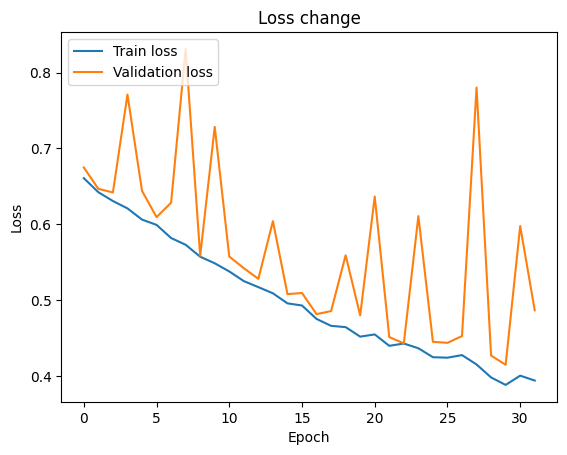

In [17]:
# Visualize loss change

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

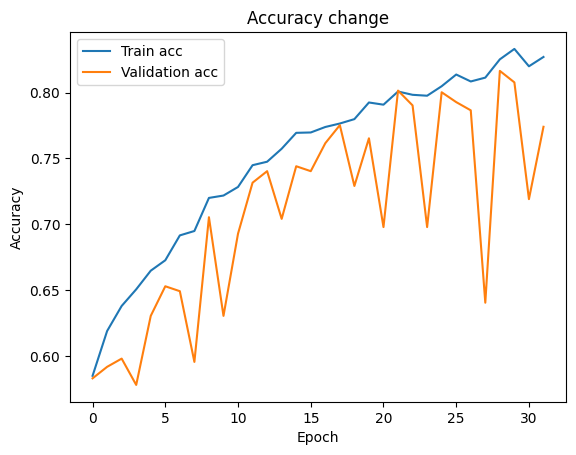

In [18]:
# Visualize accuracy change

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Accuracy change')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')
plt.show()

# Testing result & visualization of the custom CNN model

In [19]:
# Load saved model

testmodel = torch.load('./weights/best.pt')
print("Model is successfully loaded!")

Model is successfully loaded!


<ipython-input-19-3e996cf6f694>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('./weights/best.pt')


Testing...


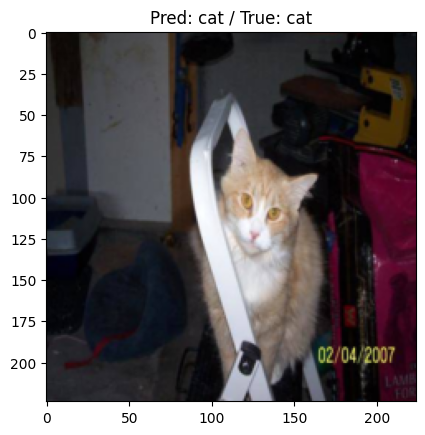

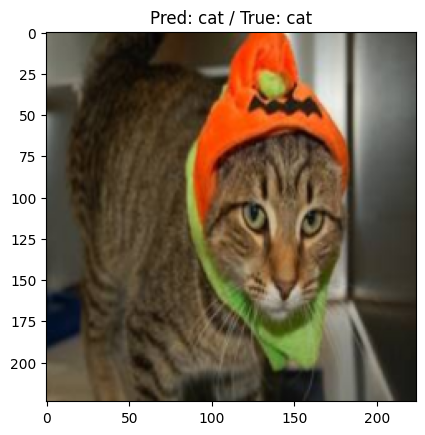

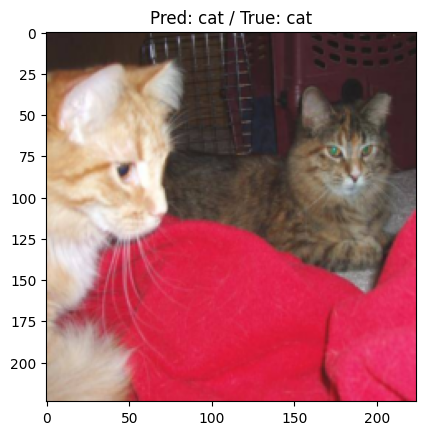

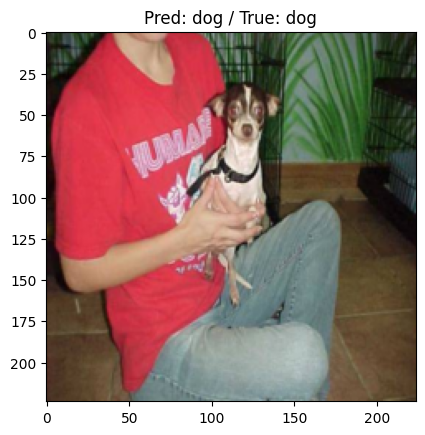

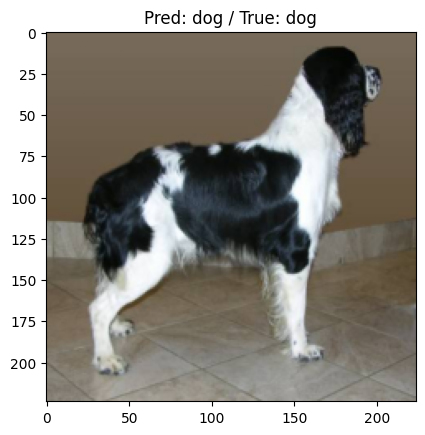

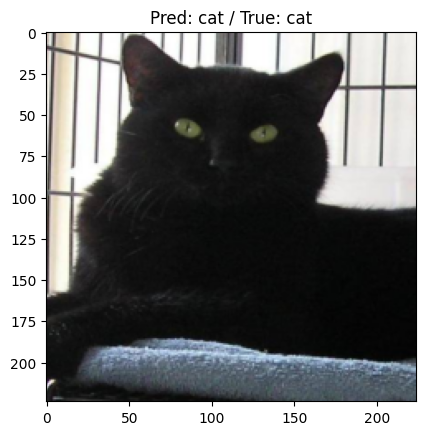

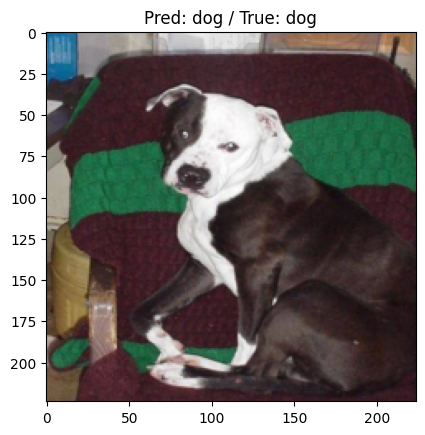

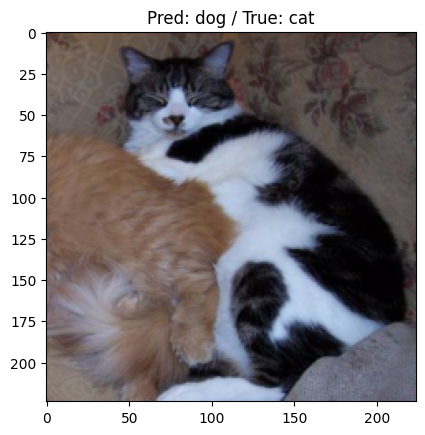

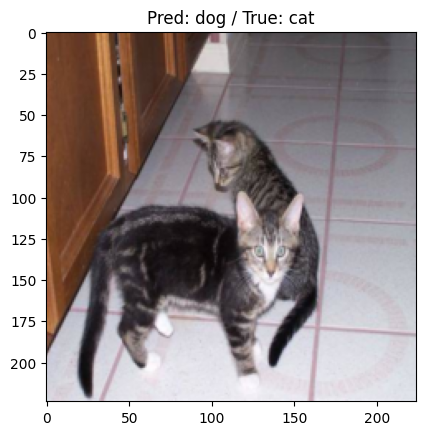

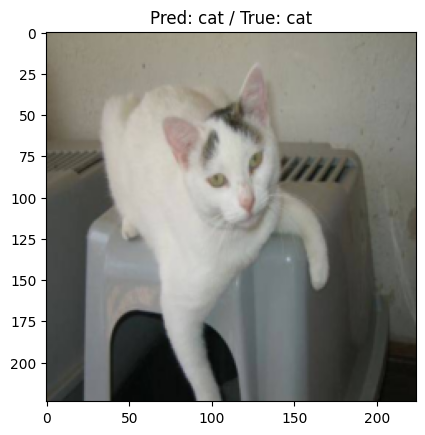

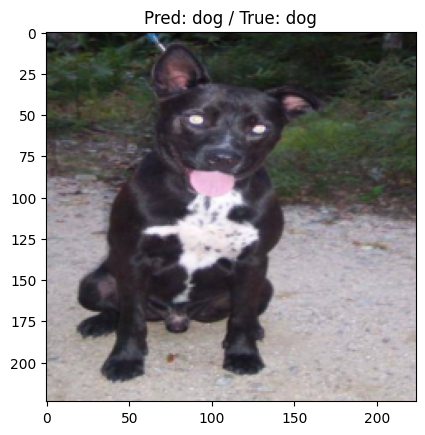


Test accuracy: 0.82


In [20]:
# Checking test accuracy & Visualization

test_correct = 0
test_total = 0
classes = ['cat', 'dog']

testmodel.eval()
print("Testing...")
with torch.no_grad():
    for idx, i in enumerate(test_loader):
        test_x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(i[0])
        test_x = test_x.type(torch.float32).to(device) # torch.tensor, [1, 3, 224, 224]
        test_y = i[1].type(torch.int64).to(device) # torch.tensor, [1]

        test_out = testmodel(test_x) # torch.tensor, [2]
        test_pred_y = torch.argmax(test_out, dim=0) # [1]

        test_total += test_y.shape[0]
        for k in range(test_y.shape[0]):
            if torch.equal(test_pred_y, test_y[k]):
                test_correct += 1

        # Visualization of test results
        if idx % 200 == 0:
          img = i[0].squeeze().permute(1,2,0).detach().cpu().numpy()
          plt.imshow(np.clip(img,0,1))
          plt.title(f"Pred: {classes[test_pred_y.detach().cpu().numpy()]} / True: {classes[test_y.detach().cpu().numpy()[0]]}")
          plt.show()

test_acc = test_correct / test_total
print("\nTest accuracy: %.2f" %(test_acc))

In [21]:
# Using more complex model
!pip install timm

# Use timm ResNet18 model

In [22]:
import timm

model = timm.create_model('resnet18', pretrained=False, num_classes=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train & Validation with the ResNet18 model

In [23]:
best_acc = 0
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
os.makedirs('./weights', exist_ok=True)
dormant = 0

for epoch in range(epochs):
    avg_train_loss = AverageMeter()
    train_correct = 0
    train_total = 0

    # train
    model.train()
    for idx, i in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}"):
        data_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
        data_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

        out = model(data_x) # torch.tensor, [b, 2]
        pred_y = torch.argmax(out, dim=1) # [b]

        train_total += data_y.shape[0]
        for i in range(data_y.shape[0]):
            if torch.equal(pred_y[i], data_y[i]):
                train_correct += 1

        loss = torch.FloatTensor([0.]).to(device)
        loss += criterion(out, data_y)
        avg_train_loss.update(loss.item(), data_x.shape[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = avg_train_loss.avg
    train_acc = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ----------------------------------------------------------------------------------------
    # Evaluation(Validation set)
    avg_val_loss = AverageMeter()
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for idx, i in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation"):
            val_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
            val_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

            val_out = model(val_x) # torch.tensor, [b, 2]
            val_pred_y = torch.argmax(val_out, dim=1) # [b]

            val_total += val_y.shape[0]
            for j in range(val_y.shape[0]):
                if torch.equal(val_pred_y[j], val_y[j]):
                    val_correct += 1

            val_loss = torch.FloatTensor([0.]).to(device)
            val_loss += criterion(val_out, val_y)
            avg_val_loss.update(val_loss.item(), val_x.shape[0])

    val_loss = avg_val_loss.avg
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if best_acc < val_acc:
        print('\nHigher validation accuracy, saving model weights...')
        print('best acc: {:4f}'.format(best_acc), 'current acc: {:.4f}'.format(val_acc))
        best_acc = val_acc
        torch.save(model,'./weights/best2.pt')
        dormant = 0

    if epoch % 1 == 0:
        print("\n[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f" %(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))
    print("★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★")

    dormant += 1
    if dormant == 10:
      print("\nEarly exiting...")
      break

print('Best validation accuracy: {:4f}'.format(best_acc))
print('Training Finished!')

Validation: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Higher validation accuracy, saving model weights...
best acc: 0.000000 current acc: 0.5680

[1/32] TrainLoss: 0.732, ValLoss: 0.683 | TrainAcc: 0.56, ValAcc: 0.57
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]



Higher validation accuracy, saving model weights...
best acc: 0.568040 current acc: 0.5843

[2/32] TrainLoss: 0.644, ValLoss: 0.695 | TrainAcc: 0.62, ValAcc: 0.58
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]



Higher validation accuracy, saving model weights...
best acc: 0.584270 current acc: 0.6367

[3/32] TrainLoss: 0.629, ValLoss: 0.642 | TrainAcc: 0.65, ValAcc: 0.64
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]



Higher validation accuracy, saving model weights...
best acc: 0.636704 current acc: 0.6429

[4/32] TrainLoss: 0.594, ValLoss: 0.656 | TrainAcc: 0.68, ValAcc: 0.64
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]



Higher validation accuracy, saving model weights...
best acc: 0.642946 current acc: 0.6692

[5/32] TrainLoss: 0.568, ValLoss: 0.593 | TrainAcc: 0.70, ValAcc: 0.67
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]



Higher validation accuracy, saving model weights...
best acc: 0.669164 current acc: 0.6879

[6/32] TrainLoss: 0.555, ValLoss: 0.579 | TrainAcc: 0.72, ValAcc: 0.69
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]



Higher validation accuracy, saving model weights...
best acc: 0.687890 current acc: 0.7091

[7/32] TrainLoss: 0.499, ValLoss: 0.567 | TrainAcc: 0.76, ValAcc: 0.71
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]



Higher validation accuracy, saving model weights...
best acc: 0.709114 current acc: 0.7129

[8/32] TrainLoss: 0.462, ValLoss: 0.560 | TrainAcc: 0.78, ValAcc: 0.71
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]



Higher validation accuracy, saving model weights...
best acc: 0.712859 current acc: 0.7890

[9/32] TrainLoss: 0.442, ValLoss: 0.443 | TrainAcc: 0.79, ValAcc: 0.79
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


[10/32] TrainLoss: 0.422, ValLoss: 0.498 | TrainAcc: 0.81, ValAcc: 0.78
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]



Higher validation accuracy, saving model weights...
best acc: 0.789014 current acc: 0.8115

[11/32] TrainLoss: 0.389, ValLoss: 0.408 | TrainAcc: 0.83, ValAcc: 0.81
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


[12/32] TrainLoss: 0.366, ValLoss: 0.513 | TrainAcc: 0.84, ValAcc: 0.78
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]



[13/32] TrainLoss: 0.341, ValLoss: 0.454 | TrainAcc: 0.85, ValAcc: 0.78
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]



Higher validation accuracy, saving model weights...
best acc: 0.811486 current acc: 0.8215

[14/32] TrainLoss: 0.326, ValLoss: 0.380 | TrainAcc: 0.86, ValAcc: 0.82
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]



Higher validation accuracy, saving model weights...
best acc: 0.821473 current acc: 0.8352

[15/32] TrainLoss: 0.299, ValLoss: 0.382 | TrainAcc: 0.87, ValAcc: 0.84
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]



Higher validation accuracy, saving model weights...
best acc: 0.835206 current acc: 0.8365

[16/32] TrainLoss: 0.292, ValLoss: 0.384 | TrainAcc: 0.87, ValAcc: 0.84
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]



Higher validation accuracy, saving model weights...
best acc: 0.836454 current acc: 0.8552

[17/32] TrainLoss: 0.265, ValLoss: 0.357 | TrainAcc: 0.89, ValAcc: 0.86
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Higher validation accuracy, saving model weights...
best acc: 0.855181 current acc: 0.8764

[18/32] TrainLoss: 0.252, ValLoss: 0.305 | TrainAcc: 0.89, ValAcc: 0.88
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]



Higher validation accuracy, saving model weights...
best acc: 0.876404 current acc: 0.8889

[19/32] TrainLoss: 0.229, ValLoss: 0.290 | TrainAcc: 0.91, ValAcc: 0.89
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]



Higher validation accuracy, saving model weights...
best acc: 0.888889 current acc: 0.9014

[20/32] TrainLoss: 0.202, ValLoss: 0.245 | TrainAcc: 0.91, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


[21/32] TrainLoss: 0.197, ValLoss: 0.266 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


[22/32] TrainLoss: 0.177, ValLoss: 0.252 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


[23/32] TrainLoss: 0.168, ValLoss: 0.465 | TrainAcc: 0.93, ValAcc: 0.84
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


[24/32] TrainLoss: 0.155, ValLoss: 0.317 | TrainAcc: 0.94, ValAcc: 0.87
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


[25/32] TrainLoss: 0.150, ValLoss: 0.300 | TrainAcc: 0.94, ValAcc: 0.88
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]



Higher validation accuracy, saving model weights...
best acc: 0.901373 current acc: 0.9101

[26/32] TrainLoss: 0.142, ValLoss: 0.216 | TrainAcc: 0.94, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


[27/32] TrainLoss: 0.133, ValLoss: 0.226 | TrainAcc: 0.94, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


[28/32] TrainLoss: 0.136, ValLoss: 0.497 | TrainAcc: 0.95, ValAcc: 0.83
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


[29/32] TrainLoss: 0.128, ValLoss: 0.290 | TrainAcc: 0.95, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]



Higher validation accuracy, saving model weights...
best acc: 0.910112 current acc: 0.9189

[30/32] TrainLoss: 0.109, ValLoss: 0.266 | TrainAcc: 0.96, ValAcc: 0.92
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


[31/32] TrainLoss: 0.116, ValLoss: 0.269 | TrainAcc: 0.95, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Higher validation accuracy, saving model weights...
best acc: 0.918851 current acc: 0.9251

[32/32] TrainLoss: 0.104, ValLoss: 0.247 | TrainAcc: 0.96, ValAcc: 0.93
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
Best validation accuracy: 0.925094
Training Finished!


# Visualize loss & accuracy of the ResNet18 model

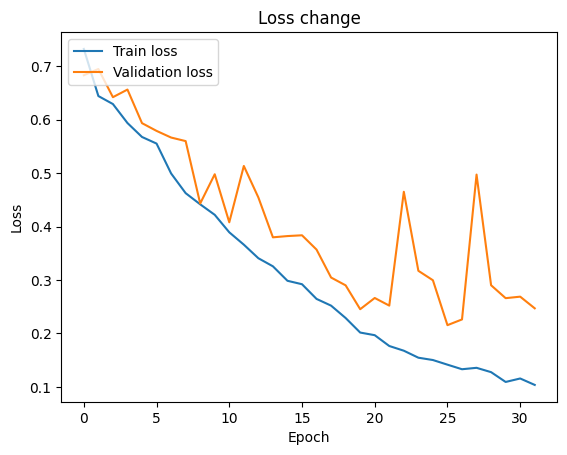

In [24]:
# Visualize loss change

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

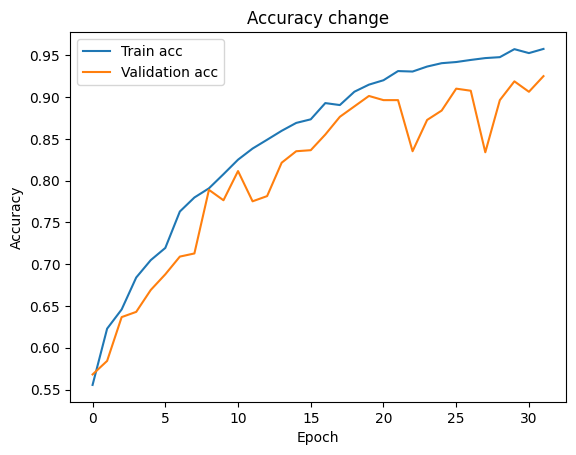

In [25]:
# Visualize accuracy change

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Accuracy change')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')
plt.show()

# Testing result & visualization of the ResNet18 model

In [26]:
# Load saved model

testmodel = torch.load('./weights/best2.pt')
print("Model is successfully loaded!")

Model is successfully loaded!


<ipython-input-26-d5821310d663>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('./weights/best2.pt')


Testing...


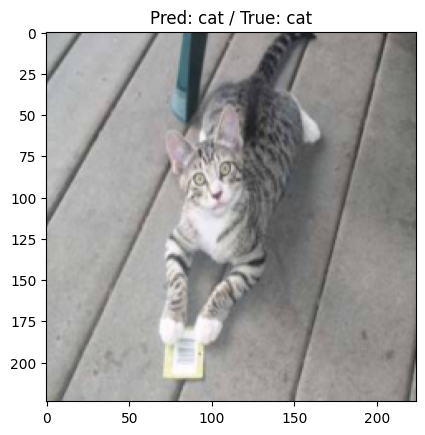

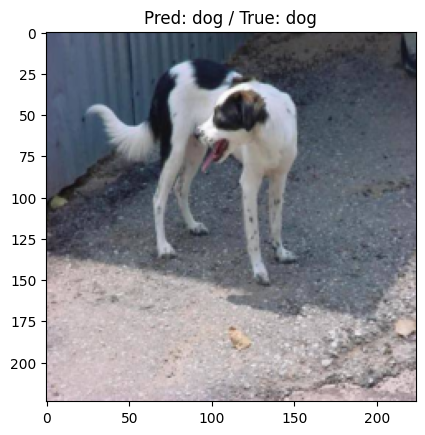

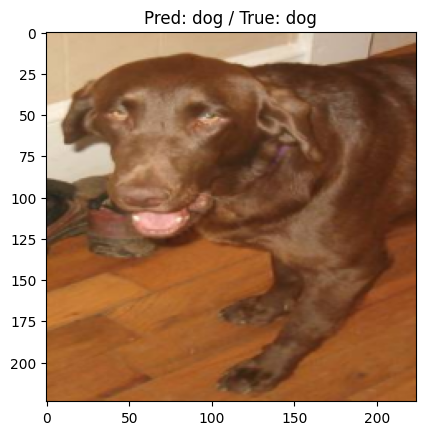

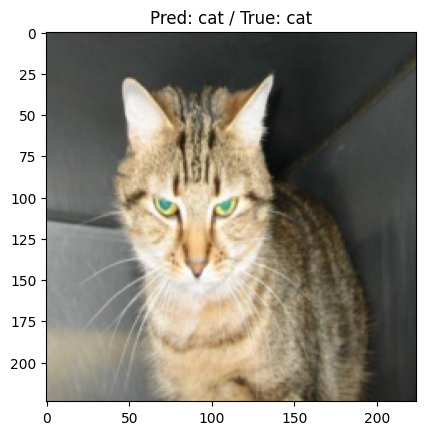

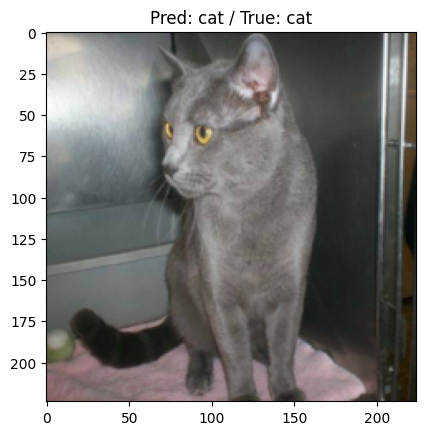

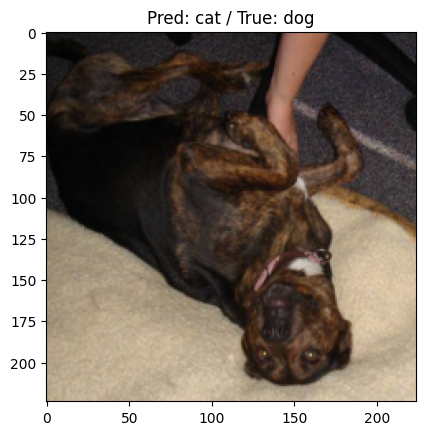

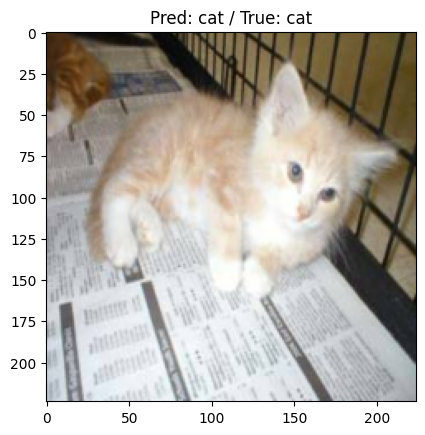

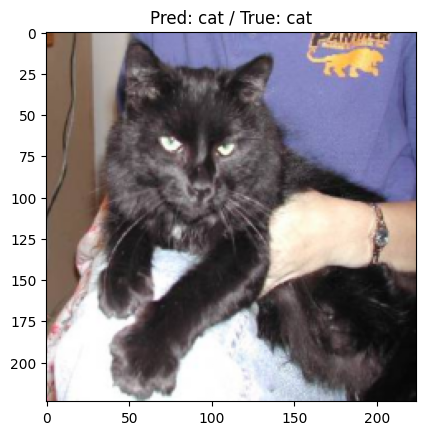

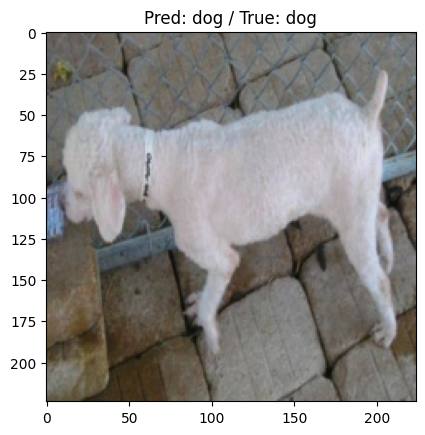

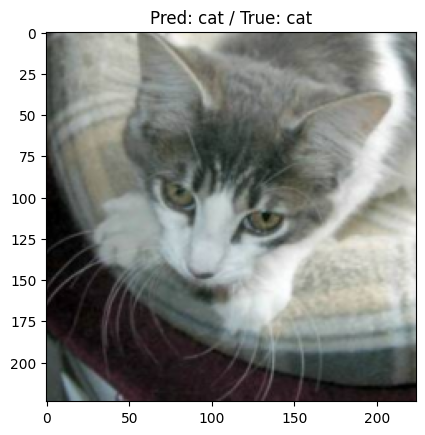

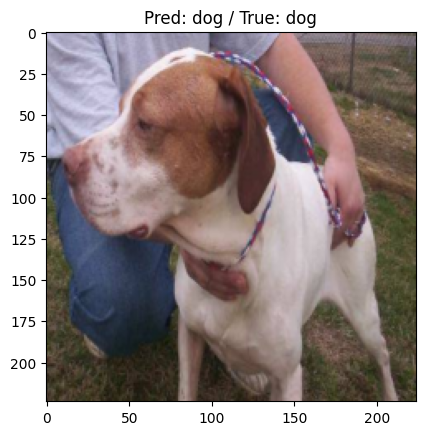


Test accuracy: 0.92


In [27]:
# Checking test accuracy & Visualization

test_correct = 0
test_total = 0
classes = ['cat', 'dog']

testmodel.eval()
print("Testing...")
with torch.no_grad():
    for idx, i in enumerate(test_loader):
        test_x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(i[0])
        test_x = test_x.type(torch.float32).to(device) # torch.tensor, [1, 3, 224, 224]
        test_y = i[1].type(torch.int64).to(device) # torch.tensor, [1]

        test_out = testmodel(test_x) # torch.tensor, [1, 2]
        test_pred_y = torch.argmax(test_out, dim=1) # [1]

        test_total += test_y.shape[0]
        for k in range(test_y.shape[0]):
            if torch.equal(test_pred_y[k], test_y[k]):
                test_correct += 1

        # Visualization of test results
        if idx % 200 == 0:
          img = i[0].squeeze().permute(1,2,0).detach().cpu().numpy()
          plt.imshow(np.clip(img,0,1))
          plt.title(f"Pred: {classes[test_pred_y.detach().cpu().numpy()[0]]} / True: {classes[test_y.detach().cpu().numpy()[0]]}")
          plt.show()

test_acc = test_correct / test_total
print("\nTest accuracy: %.2f" %(test_acc))